In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
% cd /content/drive/My\ Drive/Colab\ Notebooks/Quotation_Generation/

/content/drive/My Drive/Colab Notebooks/Quotation_Generation


In [0]:
from collections import  defaultdict

import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import math
sns.set(palette = 'gist_earth', style='white')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm_notebook as tqdm

from sklearn.manifold import TSNE

In [0]:
quotes = []
max_len = 0
min_len = 5
sent_len_dic = defaultdict(int)
with open('quotes.txt', 'r') as f:
  while True:
    quote = f.readline()
    if not quote:
      break
    words = quote.split(' ')
    sent_len = len(words)
    if sent_len < min_len:
      continue
    max_len = sent_len if sent_len > max_len else max_len
    sent_len_dic[sent_len] += 1
    flag = False
    for i in range(0,10):
      if str(i) in quote:
        flag = True
        break
    if flag == True:
      continue
    quote = quote.replace(',', ' ,').replace('.', ' .').replace('_','').strip('\n') + ' ;'
    quotes.append(quote.lower())

In [0]:
print(f'Sentences with\nmin count words : {min_len}\nmax count words : {max_len}')

Sentences with
min count words : 5
max count words : 111


In [0]:
len(quotes)

3831

In [0]:
words_dict = dict()
def unique_words(data_list):
  for x in data_list:
    for word in x.split(' '):
      words_dict[word] = 1
  return words_dict.keys()

In [0]:
words = list(unique_words(quotes))
words.sort()

In [0]:
len(words)

6361

In [0]:
word_to_int = dict()
int_to_word = dict()
vocab_len = len(words)
for i in range(0, vocab_len):
  word_to_int[words[i]] = i 
  int_to_word[i] = words[i]

In [0]:
co_occ_matrix = defaultdict(int)
window = 5 # not greater than 5
for sent in quotes:
  words = sent.split(' ')
  # first window 
  for i in range(0, window):
    for j in range(i+1, window):
      weight = 1/(j-i)
      ind_1 = word_to_int[words[i]]
      ind_2 = word_to_int[words[j]]
      if ind_1 == ind_2:
        continue
      co_occ_matrix[(ind_1, ind_2)] += weight
      co_occ_matrix[(ind_2, ind_1)] += weight
  # rest windows
  for i in range(window, len(words)):
    for j in range(i-window, i):
      weight = 1/(i-j)
      ind_1 = word_to_int[words[i]]
      ind_2 = word_to_int[words[j]]
      if ind_1 == ind_2:
        continue
      co_occ_matrix[(ind_1, ind_2)] += weight
      co_occ_matrix[(ind_2, ind_1)] += weight

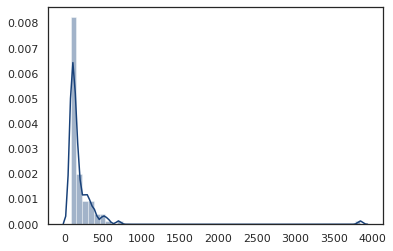

In [0]:
topk, ind = torch.topk(torch.tensor(list(co_occ_matrix.values())), 200)
sns.distplot(topk)

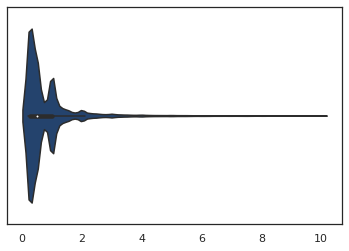

In [0]:
elem_den = []
for i in co_occ_matrix.values():
  if i > 0 and i < 10:
    elem_den.append(i)
sns.violinplot(x = elem_den)

In [0]:
tot_pairs = len(co_occ_matrix)
p1, p2,occs = list(), list(), list()
for i in co_occ_matrix.keys():
    p1.append(i[0])
    p2.append(i[1])
    occs.append(co_occ_matrix[i])
p1 = np.array(p1)
p2 = np.array(p2)
occs = np.array(occs)

In [0]:
occs.size

249808

In [0]:
def get_batch(batch_size):
  ind = np.random.permutation(occs.size).tolist()
  i = 0
  for i in range(0, tot_pairs, batch_size):
    batch_ids = ind[i:i+batch_size]
    yield p1[batch_ids], p2[batch_ids], occs[batch_ids]

In [0]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [0]:
class Glove(nn.Module) :
  def __init__(self, vocab_len, num_dim,):
    super(Glove, self).__init__()
    self.ui = nn.Embedding(vocab_len, num_dim).to(device)
    self.uj = nn.Embedding(vocab_len, num_dim).to(device)
    self.bi = nn.Embedding(vocab_len, 1).to(device)
    self.bj = nn.Embedding(vocab_len, 1).to(device)

    self.ui.weight.data.uniform_(-1,1)
    self.uj.weight.data.uniform_(-1,1)
    self.bi.weight.data.zero_()
    self.bj.weight.data.zero_()
  
  def forward(self, i_vecs, j_vecs):
    i_s = self.ui(i_vecs)
    j_s = self.uj(j_vecs)
    b_i = torch.squeeze(self.bi(i_vecs))
    b_j = torch.squeeze(self.bj(j_vecs))
    return torch.sum(i_s * j_s, dim = 1) + b_i + b_j

In [0]:
num_dim = 128
glove = Glove(vocab_len, num_dim).to(device)

In [0]:
def f_x(x, x_max, alpha):
  x = (x/x_max)**alpha
  return torch.min(x, torch.ones_like(x)).to(device)

def weight_mse(w_x, x, log_x):
  loss = w_x * F.mse_loss(x, log_x, reduction='none')
  return torch.mean(loss).to(device)

In [0]:
epochs = 100
batch_size = 512
batch_count = 0
x_max = 1
alpha = 0.75
loss_trace = []
n_bathces = int(math.floor(len(occs)/batch_size))
optimizer = optim.Adagrad(glove.parameters(), lr=0.05)
for epoch in tqdm(range(epochs)):
  batch_count = -1
  for ind_1, ind_2, occ in get_batch(batch_size):
    batch_count += 1
    occ = torch.FloatTensor(occ).to(device)
    optimizer.zero_grad()
    y_hat = glove.forward(torch.tensor(ind_1).to(device), 
                          torch.tensor(ind_2).to(device))
    w_x = f_x(occ, x_max, alpha)
    loss = weight_mse(w_x, y_hat, torch.log(occ))
    loss.backward()
    optimizer.step()
    loss_trace.append(loss.item())
    if batch_count == n_bathces:
      break
  print(f"Epoch : {epoch + 1} ----> Loss : {loss_trace[-1]}")

Epoch : 1 ----> Loss : 4.796401500701904
Epoch : 2 ----> Loss : 2.014411211013794
Epoch : 3 ----> Loss : 1.426303744316101
Epoch : 4 ----> Loss : 1.0219517946243286
Epoch : 5 ----> Loss : 0.9586169719696045
Epoch : 6 ----> Loss : 0.7812556624412537
Epoch : 7 ----> Loss : 0.7010027170181274
Epoch : 8 ----> Loss : 0.6730878353118896
Epoch : 9 ----> Loss : 0.505446195602417
Epoch : 10 ----> Loss : 0.48864707350730896
Epoch : 11 ----> Loss : 0.42977482080459595
Epoch : 12 ----> Loss : 0.4258069694042206
Epoch : 13 ----> Loss : 0.40871748328208923
Epoch : 14 ----> Loss : 0.3873564898967743
Epoch : 15 ----> Loss : 0.3715595602989197
Epoch : 16 ----> Loss : 0.38262832164764404
Epoch : 17 ----> Loss : 0.3344598412513733
Epoch : 18 ----> Loss : 0.3035099506378174
Epoch : 19 ----> Loss : 0.29445740580558777
Epoch : 20 ----> Loss : 0.2994334101676941
Epoch : 21 ----> Loss : 0.20549406111240387
Epoch : 22 ----> Loss : 0.24363911151885986
Epoch : 23 ----> Loss : 0.2681289613246918
Epoch : 24 ----> 

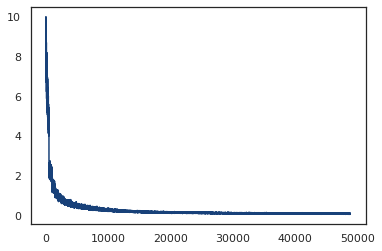

In [0]:
plt.plot(loss_trace)

In [0]:
torch.save(glove, 'glove.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Glove. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
glove = torch.load('glove.pth',device)

In [0]:
glove.eval()

Glove(
  (ui): Embedding(6361, 128)
  (uj): Embedding(6361, 128)
  (bi): Embedding(6361, 1)
  (bj): Embedding(6361, 1)
)

In [0]:
emb_i = glove.ui.weight.cpu().data.numpy()
emb_j = glove.uj.weight.cpu().data.numpy()
emb = emb_i + emb_j

In [0]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300,metric='cosine')
n_points = 100
emb_tsne = tsne.fit_transform(emb[:n_points, :])

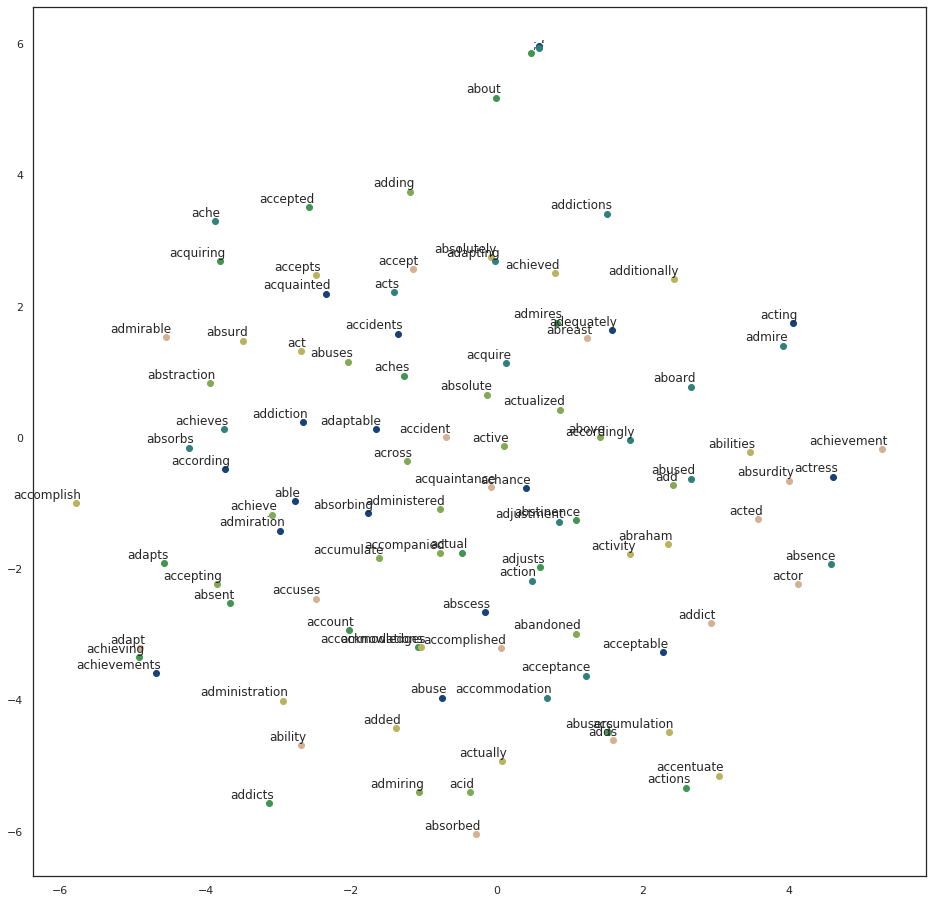

In [0]:
labels = list(word_to_int.keys())[:n_points]
x = emb_tsne[:,0]
y = emb_tsne[:,1]
plt.figure(figsize=(16, 16)) 
for i in range(n_points):
  plt.scatter(x[i],y[i])
  plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2),
               textcoords='offset points', ha='right', va='bottom')

In [0]:
max_sent_len = 50
window = 5
sequences, next_words = [], []
for quote in quotes:
  words = quote.split(' ')
  for i in range(0,len(words) - window + 1):
    sequences.append(words[i:i+window])
    if (i + window) < len(words):
      next_words.append(words[i+window])
    else:
      next_words.append(';')

In [0]:
print("{0:^40} {1}".format('Sequence', 'Next_Word'))
print('-'*50)
for i in range(20):
  print(f"{' '.join(sequences[i]) : <40} {next_words[i] : ^10}")

                Sequence                 Next_Word
--------------------------------------------------
acting is the least mysterious               of    
is the least mysterious of                  all    
the least mysterious of all                crafts  
least mysterious of all crafts               .     
mysterious of all crafts .                whenever 
of all crafts . whenever                     we    
all crafts . whenever we                    want   
crafts . whenever we want                something 
. whenever we want something                from   
whenever we want something from           somebody 
we want something from somebody              or    
want something from somebody or             when   
something from somebody or when              we    
from somebody or when we                    want   
somebody or when we want                     to    
or when we want to                          hide   
when we want to hide                     something 
we want to hid

In [0]:
tot_seq = len(next_words)
print(tot_seq)

65915


In [0]:
X = np.zeros((tot_seq, window, num_dim))
Y = np.zeros((tot_seq,vocab_len))
for i,seq in enumerate(sequences):
  for j,word in enumerate(seq):
    num_id = word_to_int[word]
    X[i][j] = np.squeeze(emb[num_id])
  num_id = word_to_int[next_words[i]]
  Y[i][num_id] = 1

In [0]:
X.shape, Y.shape

((65915, 5, 128), (65915, 6361))

In [0]:
def get_batches_x(tot_seq, batch_size):
  ind = np.random.permutation(tot_seq).tolist()
  i = 0
  for i in range(0, tot_seq, batch_size):
    batch_ids = ind[i:i+batch_size]
    yield X[batch_ids], Y[batch_ids]

In [0]:
class Quote_Generator(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_len):
    super(Quote_Generator, self).__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(embed_size, hidden_size, batch_first = True).to(device)
    self.dropout = nn.Dropout(0.4)
    self.dense = nn.Linear(hidden_size*5, vocab_len).to(device)
  
  def forward(self, x, prev_state):
    output, state = self.lstm(x)
    output = self.dropout(output)
    logits = self.dense(output.reshape(-1, hidden_size*5))
    return logits, state

  def zero_states(self, batch_size):
    return (torch.zeros(1, batch_size, self.hidden_size).to(device), 
            torch.zeros(1, batch_size, self.hidden_size).to(device))

In [0]:
def entropy_loss(y, y_hat):
  y_hat = F.softmax(y_hat, dim = 1)
  ll = - (y * torch.log(y_hat))
  return torch.sum(ll, dim = 1).mean().to(device)

In [0]:
embed_size = 128
hidden_size = 64
qt_gen = Quote_Generator(embed_size, hidden_size, vocab_len).to(device)

In [0]:
epochs = 101
batch_size = 4096
losses = []
optimizer = torch.optim.Adam(qt_gen.parameters(), lr=0.001)
for epoch in tqdm(range(epochs)):
  batches = get_batches_x(tot_seq, batch_size)
  h_h, h_c = qt_gen.zero_states(batch_size)
  for x,y in batches:
    qt_gen.train()
    optimizer.zero_grad()
    x = torch.tensor(x).float().to(device)
    y = torch.tensor(y).long().to(device)
    logits, (h_h, h_c) = qt_gen(x, (h_h, h_c))
    loss = entropy_loss(y, logits)
    h_h.detach()
    h_c.detach()
    loss.backward()
    _ = nn.utils.clip_grad_norm_(qt_gen.parameters(), 5)
    optimizer.step()
    losses.append(loss.item())
  if (epoch) % 10 == 0:
    print(f"Epoch : {epoch} ----> Loss : {np.array(losses).mean()}")
  losses = []

Epoch : 0 ----> Loss : 1.981710391886094
Epoch : 10 ----> Loss : 1.9763988116208244
Epoch : 20 ----> Loss : 1.9651567234712488
Epoch : 30 ----> Loss : 1.9701273721807144
Epoch : 40 ----> Loss : 1.9645351802601534
Epoch : 50 ----> Loss : 1.9601879961350386
Epoch : 60 ----> Loss : 1.9378872478709501
Epoch : 70 ----> Loss : 1.958003415780909
Epoch : 80 ----> Loss : 1.9386976045720719
Epoch : 90 ----> Loss : 1.9374018486808329
Epoch : 100 ----> Loss : 1.945599780363195


In [0]:
torch.save(qt_gen, 'qt_gen.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Quote_Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
qt_gen = torch.load('qt_gen.pth', device)
qt_gen.eval()

Quote_Generator(
  (lstm): LSTM(128, 64, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (dense): Linear(in_features=320, out_features=6361, bias=True)
)

In [0]:
def predict(x, temp):
  probs = F.softmax(x / temp, dim = 0)
  probs = np.squeeze(probs.detach().cpu().numpy())
  ind = np.random.choice(6361, 1, p = probs)
  return ind[0]

In [0]:
generated_text = ['there','is','no','one','love']
curr_len = 0
embeds = []
is_end = word_to_int[';']

qt_gen.eval()

for i in generated_text:
  embeds.append(emb[word_to_int[i]])

while(curr_len < 50):
  curr_len += 1
  input_tensor = torch.Tensor(embeds).view(1,5,128).float().to(device)
  h_h, h_c = qt_gen.zero_states(1)
  output, (h_h, h_c) = qt_gen(input_tensor, (h_h,h_c))
  word_ind = predict(output[-1], 1.6)
  embeds[0][:4].tolist().extend(emb[word_ind])
  generated_text.append(int_to_word[word_ind])
  if word_ind == is_end:
    break

In [0]:
' '.join(generated_text)

"there is no one love or all just or all for the we be so no are , gone in . never hope too that's hope we really in his , gets life your because . of too you the them all yourself . that often all mother everything no in you pain , must"

In [0]:
torch.cuda.empty_cache()